In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Customização dos gráficos
sns.set_palette("deep")
sns.set_style("darkgrid")

mpl.rc("axes", labelsize=12, titlesize=14)
mpl.rc("figure", figsize=(8,4))

title_style = dict(fontweight="heavy", fontfamily="arial")
scatter_style = dict(linewidth=0.2, edgecolor="k", alpha=0.85)

# Carregando o conjunto de dados

In [3]:
df = pd.read_csv("houses_to_rent_v2.csv")

In [4]:
df.head()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
0,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0,41,3841
3,Porto Alegre,51,2,1,0,2,acept,not furnished,270,1112,22,17,1421
4,São Paulo,25,1,1,0,1,not acept,not furnished,0,800,25,11,836


In [5]:
df.shape

(10692, 13)

# Análise Exploratória de Dados

In [6]:
# Verifica as colunas e os seus dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10692 entries, 0 to 10691
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   city                 10692 non-null  object
 1   area                 10692 non-null  int64 
 2   rooms                10692 non-null  int64 
 3   bathroom             10692 non-null  int64 
 4   parking spaces       10692 non-null  int64 
 5   floor                10692 non-null  object
 6   animal               10692 non-null  object
 7   furniture            10692 non-null  object
 8   hoa (R$)             10692 non-null  int64 
 9   rent amount (R$)     10692 non-null  int64 
 10  property tax (R$)    10692 non-null  int64 
 11  fire insurance (R$)  10692 non-null  int64 
 12  total (R$)           10692 non-null  int64 
dtypes: int64(9), object(4)
memory usage: 1.1+ MB


Apenas a coluna __floor__ está com o dtype errado. Iremos analisar isso melhor na sequência.

In [7]:
# Resumo estatístico das variáveis numéricas
df.describe().T

,count,mean,std,min,25%,50%,75%,max
area,10692.0,149.217920,537.016942,11.0,56.00,90.0,182.0,46335.0
rooms,10692.0,2.506079,1.171266,1.0,2.00,2.0,3.0,13.0
bathroom,10692.0,2.236813,1.407198,1.0,1.00,2.0,3.0,10.0
parking spaces,10692.0,1.609147,1.589521,0.0,0.00,1.0,2.0,12.0
hoa (R$),10692.0,1174.021698,15592.305248,0.0,170.00,560.0,1237.5,1117000.0
rent amount (R$),10692.0,3896.247194,3408.545518,450.0,1530.00,2661.0,5000.0,45000.0
property tax (R$),10692.0,366.704358,3107.832321,0.0,38.00,125.0,375.0,313700.0
fire insurance (R$),10692.0,53.300879,47.768031,3.0,21.00,36.0,68.0,677.0
total (R$),10692.0,5490.487000,16484.725912,499.0,2061.75,3581.5,6768.0,1120000.0


Aparentemente há outliers. Devemos visualizar os dados antes de tomar qualquer decisão.

__Valores únicos__

In [8]:
# Verifica o número de valores únicos de cada coluna
df.nunique()

city                      5
area                    517
rooms                    11
bathroom                 10
parking spaces           11
floor                    35
animal                    2
furniture                 2
hoa (R$)               1679
rent amount (R$)       1195
property tax (R$)      1243
fire insurance (R$)     216
total (R$)             5751
dtype: int64

In [9]:
# Printa todos os valores únicos das colunas definidas como object
for col in df.columns:
    if df[col].dtype == "object":
        print(f"{col}:", df[col].unique(), "\n")

city: ['São Paulo' 'Porto Alegre' 'Rio de Janeiro' 'Campinas' 'Belo Horizonte'] 

floor: ['7' '20' '6' '2' '1' '-' '4' '3' '10' '11' '24' '9' '8' '17' '18' '5'
 '13' '15' '16' '14' '26' '12' '21' '19' '22' '27' '23' '35' '25' '46'
 '28' '29' '301' '51' '32'] 

animal: ['acept' 'not acept'] 

furniture: ['furnished' 'not furnished'] 



Notas:
- A coluna __floor__ tem um valor "-", por isso o pandas definiu que ela seria do tipo string. Podemos substituir o tracinho pelo número 0
- "acept" está escrito errado
- Podemos remover "(R$)" do nome de algumas colunas
- Podemos substituir o espaço no nome das colunas por um underline

In [10]:
# Substitui o traço por 0 e converte a coluna para int
df["floor"] = df["floor"].str.replace("-", "0").astype(int)
print(sorted(df["floor"].unique()), "\n")
df.dtypes

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 32, 35, 46, 51, 301] 



city                   object
area                    int64
rooms                   int64
bathroom                int64
parking spaces          int64
floor                   int32
animal                 object
furniture              object
hoa (R$)                int64
rent amount (R$)        int64
property tax (R$)       int64
fire insurance (R$)     int64
total (R$)              int64
dtype: object

In [11]:
# Corrige a coluna animal
df["animal"] = df["animal"].map({"acept":"accept", "not acept":"not accept"})

# Remove "(R$)" das colunas
df.columns = df.columns.map(lambda x: x.replace(" (R$)", ""))

# Substitui o espaço por underline
df.columns = df.columns.map(lambda x: x.replace(" ", "_"))

df.head()

,city,area,rooms,bathroom,parking_spaces,floor,animal,furniture,hoa,rent_amount,property_tax,fire_insurance,total
0,São Paulo,70,2,1,1,7,accept,furnished,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,20,accept,not furnished,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,6,accept,not furnished,1000,2800,0,41,3841
3,Porto Alegre,51,2,1,0,2,accept,not furnished,270,1112,22,17,1421
4,São Paulo,25,1,1,0,1,not accept,not furnished,0,800,25,11,836


__Valores ausentes__

In [12]:
# Verifica o número de valores ausente por coluna
df.isna().sum()

city              0
area              0
rooms             0
bathroom          0
parking_spaces    0
floor             0
animal            0
furniture         0
hoa               0
rent_amount       0
property_tax      0
fire_insurance    0
total             0
dtype: int64

Não há valores ausentes. Podemos visualizar os dados.

## Variáveis numéricas

In [13]:
# Separa em variáveis numéricas e categóricas
nums = df.select_dtypes(exclude="object").columns.tolist()
cats = df.select_dtypes(include="object").columns.tolist()
print(f"Variáveis numéricas: {nums}")
print(f"Variáveis categóricas: {cats}")

Variáveis numéricas: ['area', 'rooms', 'bathroom', 'parking_spaces', 'floor', 'hoa', 'rent_amount', 'property_tax', 'fire_insurance', 'total']
Variáveis categóricas: ['city', 'animal', 'furniture']


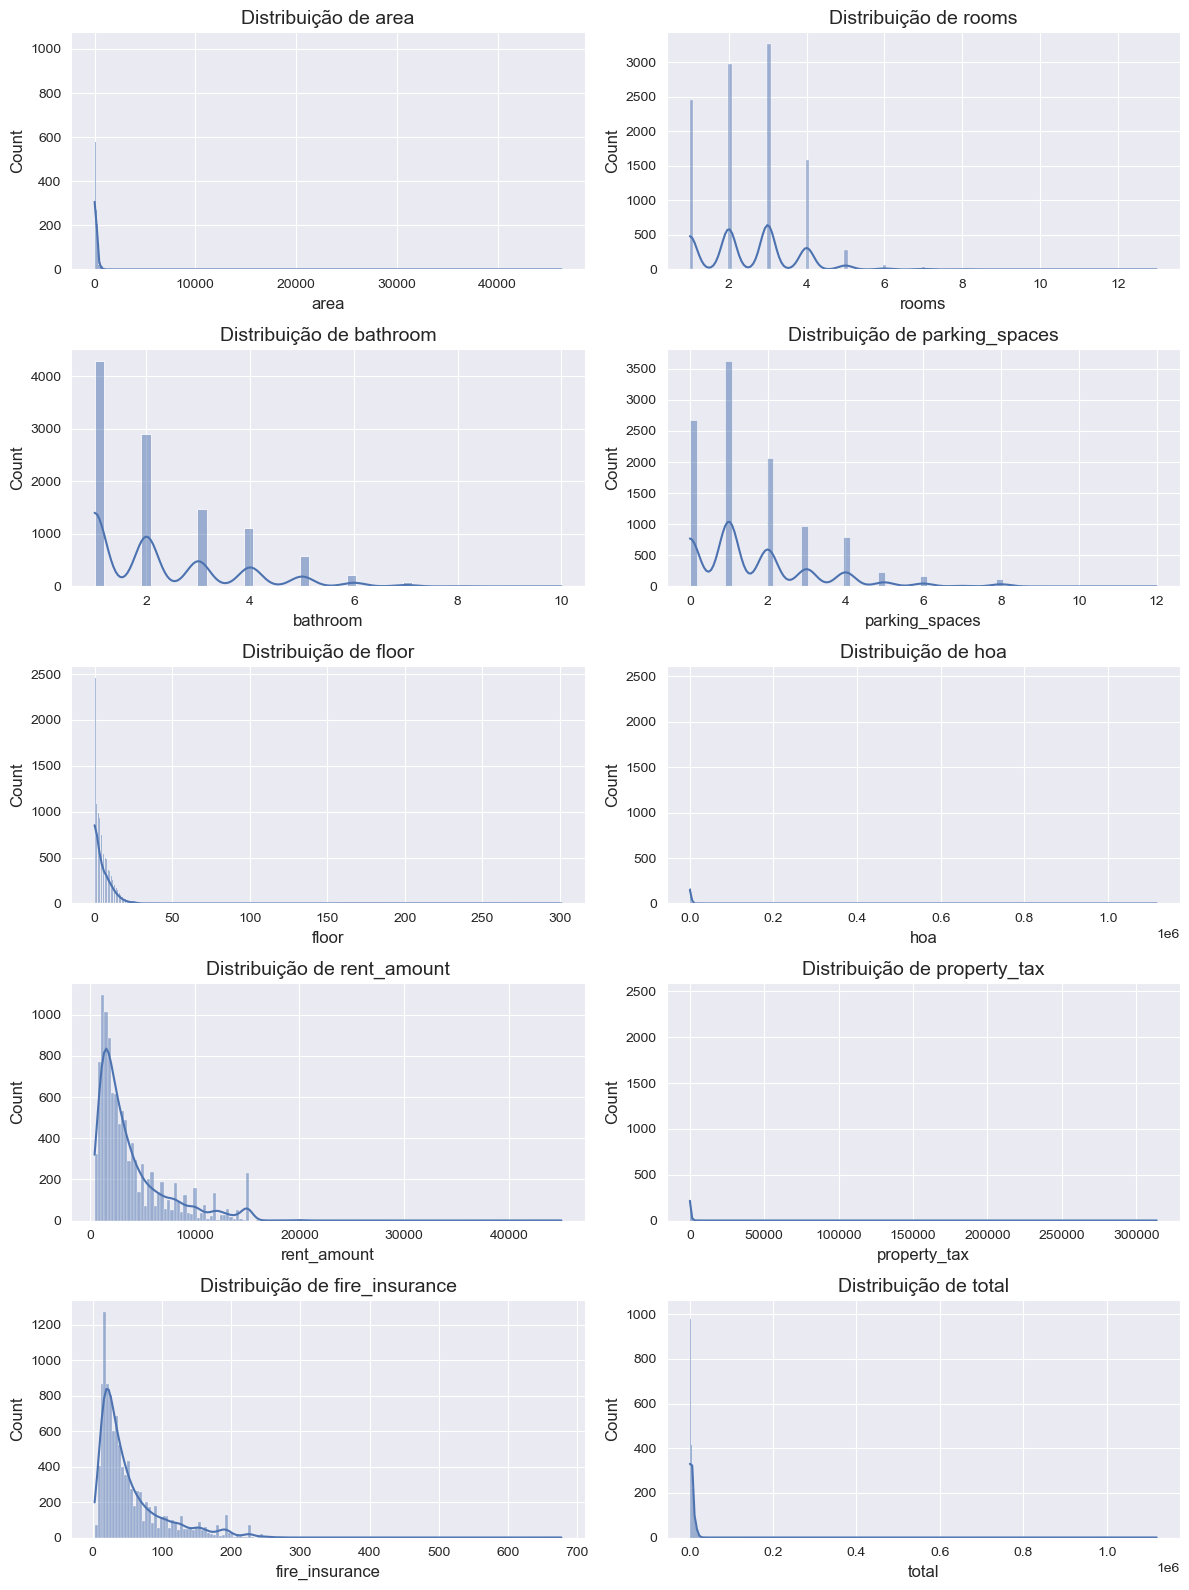

In [14]:
# Histograma para as variáveis numéricas
fig = plt.figure(figsize=(12, 16))

for i, col in enumerate(nums):
    plt.subplot(5, 2, i + 1)
    sns.histplot(data=df, x=col, kde=True)
    plt.title(f"Distribuição de {col}")
    
fig.tight_layout()    
plt.show()

Todas as colunas numéricas são assimétricas, com a cauda à direita. Vamos visualizar a questão dos outliers com um boxplot.

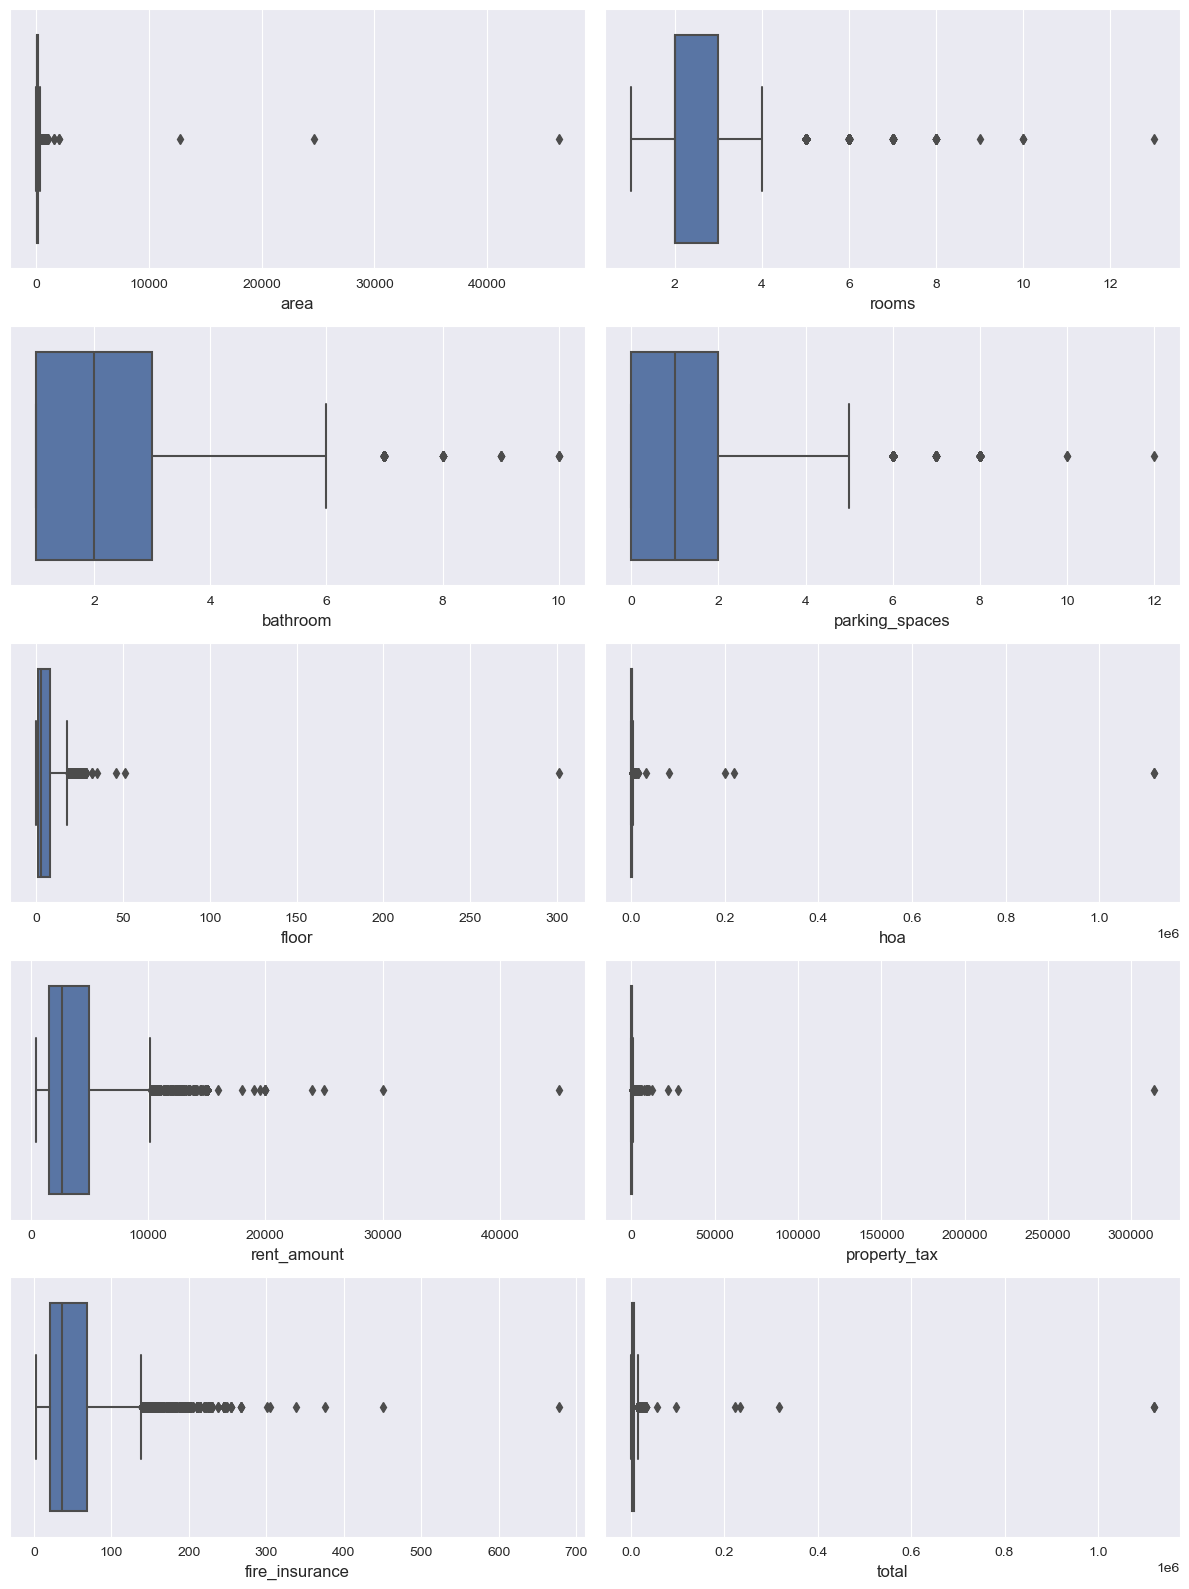

In [15]:
# Boxplot para as variáveis numéricas
fig = plt.figure(figsize=(12, 16))

for i, col in enumerate(nums):
    plt.subplot(5, 2, i + 1)
    sns.boxplot(data=df, x=col)
    
fig.tight_layout()    
plt.show()

Como suspeitado anteriormente, há outliers. Podemos remover os mais críticos.

In [16]:
# Número de linhas antes
antes = len(df)

# Filtros para a remoção de linhas
filt1 = df["area"] < 10000
filt2 = df["floor"] < 300
filt3 = df["hoa"] < 1000000
filt4 = df["property_tax"] < 300000
df = df.loc[(filt1) & (filt2) & (filt3) & (filt4)]

# Número de linhas depois
depois = len(df)
print(f"{antes - depois} linhas foram removidas")

7 linhas foram removidas


## Variáveis categóricas

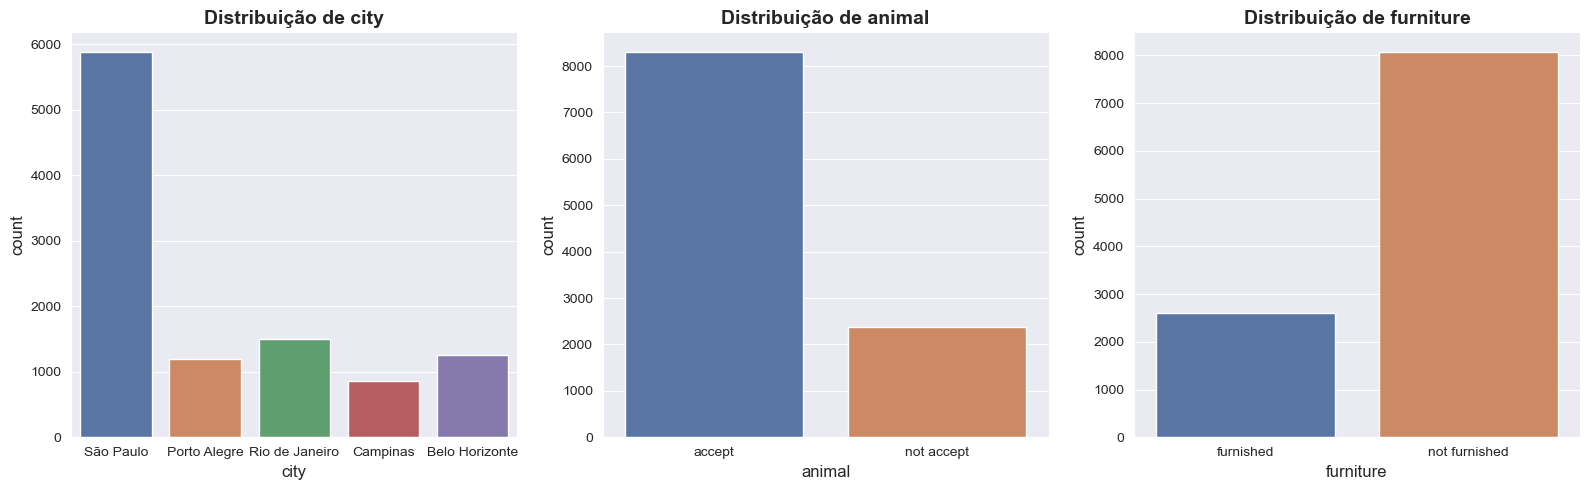

In [17]:
# Count plot para as variáveis categóricas
fig = plt.figure(figsize=(16, 5))

for i, col in enumerate(cats):
    plt.subplot(1, 3, i + 1)
    sns.countplot(data=df, x=col)
    plt.title(f"Distribuição de {col}", **title_style)
    
fig.tight_layout()    
plt.show()

Notas:
- A maioria das casas estão localizadas em São Paulo
- A maioria aceita animais de estimação
- A maioria está sem mobília

## Matriz de correlação

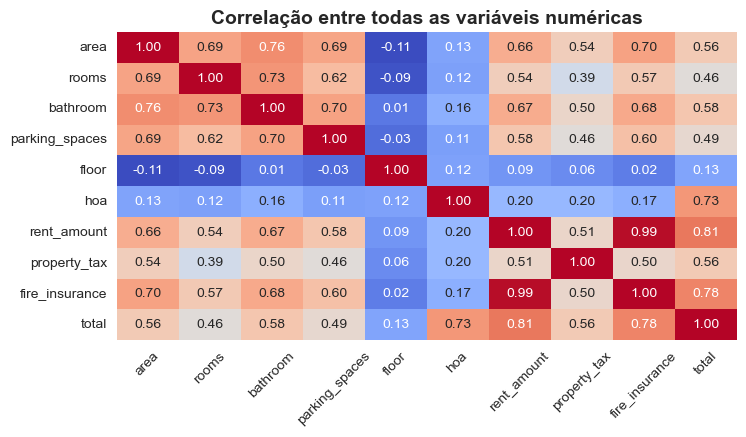

In [18]:
# Plota a matriz de correlação
sns.heatmap(df[nums].corr(), annot=True, fmt=".2f", cmap="coolwarm", cbar=False)
plt.xticks(rotation=45)
plt.title("Correlação entre todas as variáveis numéricas", **title_style)

plt.show()

Como __total__ é a soma das variáveis __hoa__, __rent amount__, __property tax__ e __fire insurance__, não faz sentido usá-las. Há uma correlação muito forte entre todas elas.<br>
A decisão a ser tomada aqui dependerá do problema do negócio. No caso, manteremos apenas a variável __rent amount__, que será o nosso alvo.

In [19]:
# Dropa as colunas desnecessárias
df.drop(["hoa", "property_tax", "fire_insurance", "total"], axis=1, inplace=True)

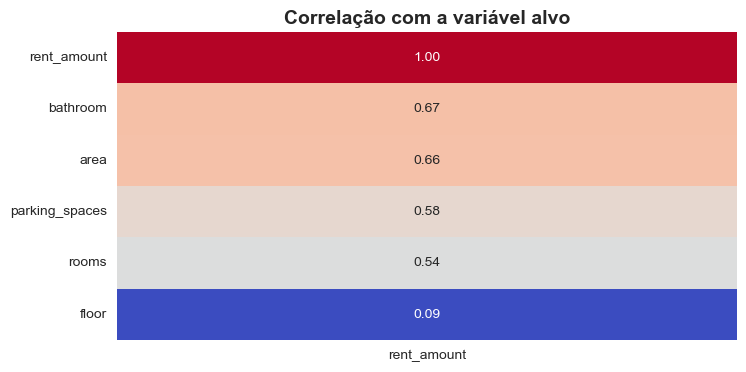

In [20]:
# Atualiza a variável nums
nums = df.select_dtypes(exclude="object").columns.tolist()

# Plota a correlação das outras variáveis com o alvo
corr_sorted = df[nums].corr()["rent_amount"].sort_values(ascending=False).to_frame()
sns.heatmap(corr_sorted, annot=True, fmt=".2f", cmap="coolwarm", cbar=False)
plt.title("Correlação com a variável alvo", **title_style)

plt.show()

Com a exceção da coluna __floor__, todas as outras possuem uma boa correlação com a variável alvo.<br>
Vamos explorar um pouco mais essa correlação com gráficos de dispersão.

## Análise bivariada

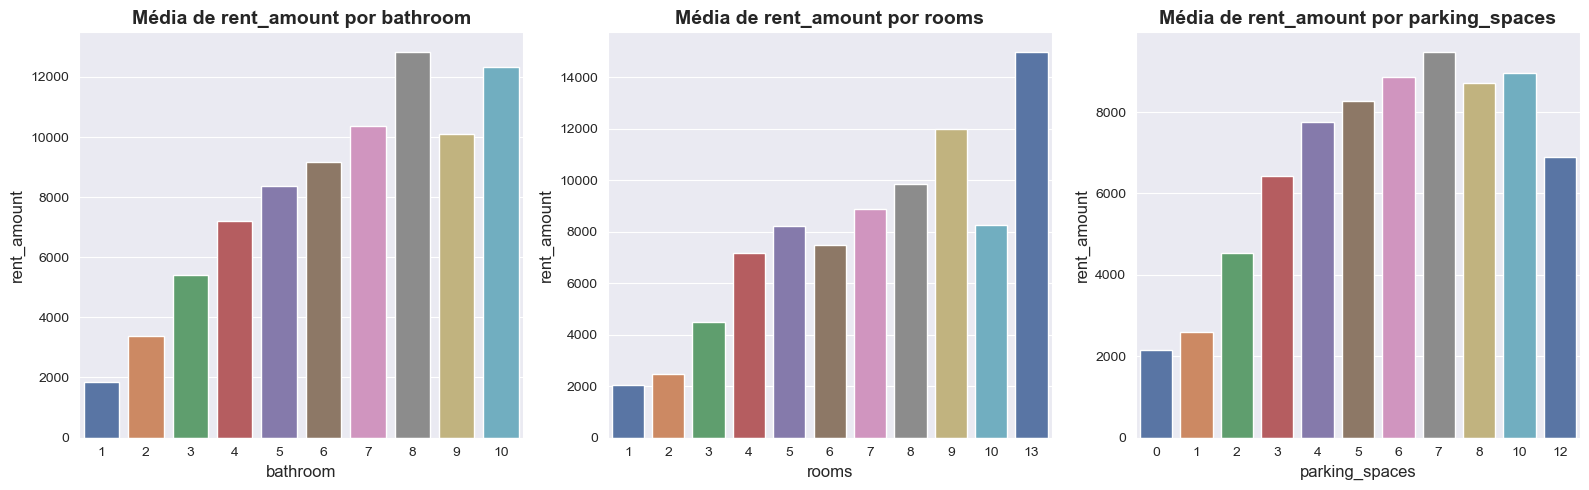

In [21]:
# Seleciona colunas com poucos valores únicos
cols_strip = ["bathroom", "rooms", "parking_spaces"]

# Faz um barplot para cada uma das colunas
fig = plt.figure(figsize=(16, 5))
for i, col in enumerate(cols_strip):
    plt.subplot(1, 3, i + 1)
    sns.barplot(data=df, x=col, y="rent_amount", estimator="mean", errorbar=None, palette=sns.color_palette("deep"))
    plt.title(f"Média de rent_amount por {col}", **title_style)

fig.tight_layout()
plt.show()

Conforme mostrado pela matriz de correlação, o preço tende a aumentar conforme aumenta o número banheiros, quartos e vagas na garagem.<br>

Vamos fazer o mesmo para as variáveis categóricas.

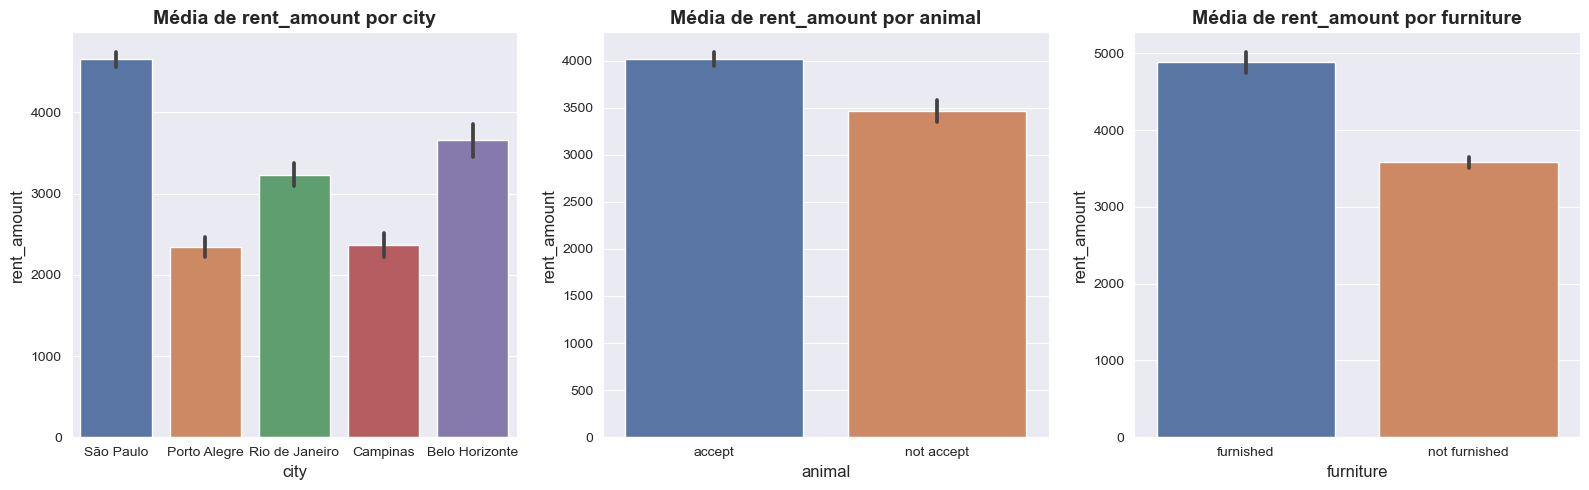

In [22]:
# Seleciona colunas categóricas
cols_cats = ["city", "animal", "furniture"]

# Faz um barplot para cada uma das colunas
fig = plt.figure(figsize=(16, 5))
for i, col in enumerate(cols_cats):
    plt.subplot(1, 3, i + 1)
    ax = sns.barplot(data=df, x=col, y="rent_amount", estimator="mean")
    plt.title(f"Média de rent_amount por {col}", **title_style)

fig.tight_layout()
plt.show()

Notas:
- São Paulo tem o aluguel mais caro na média, enquanto Porto Alegre tem o menor
- Moradias que aceitam pets têm o maior preço médio
- Moradias mobiliadas têm o aluguel mais caro na média

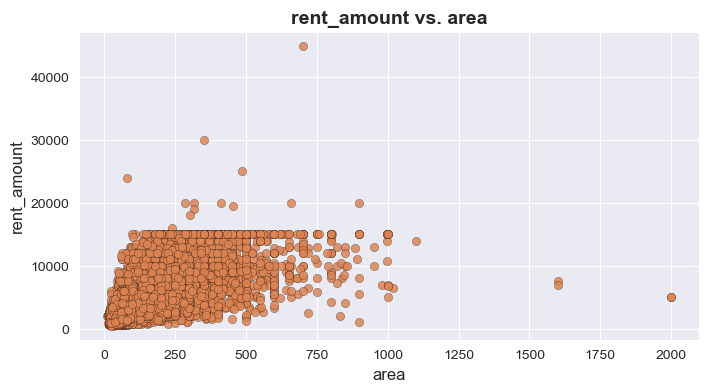

In [23]:
# Plota gráfico de dispersão entre area e rent amount
sns.scatterplot(data=df, x="area", y="rent_amount", color="C1", **scatter_style)
plt.title("rent_amount vs. area", **title_style)

plt.show()

A maioria das moradias têm menos de 1000 m² e o preço aumenta com o aumento da área.

# Pré-processamento

In [24]:
# Separa o dataset em X e y
y = df["rent_amount"]
X = df.drop("rent_amount", axis=1)

# Atualiza a variável nums
nums = X.select_dtypes(exclude="object").columns.tolist()
nums

['area', 'rooms', 'bathroom', 'parking_spaces', 'floor']

In [25]:
# Para a variável city, iremos utilizar a função LabelEncoder()
encoder = LabelEncoder()
X["city"] = encoder.fit_transform(X["city"])

# Para o restante das variáveis categóricas, iremos utilizar o map
# Isso porque animal e furniture são binárias do tipo sim ou não
X["animal"] = X["animal"].map({"not accept":0, "accept":1})
X["furniture"] = X["furniture"].map({"not furnished":0, "furnished":1})
X.head()

,city,area,rooms,bathroom,parking_spaces,floor,animal,furniture
0,4,70,2,1,1,7,1,1
1,4,320,4,4,0,20,1,0
2,2,80,1,1,1,6,1,0
3,2,51,2,1,0,2,1,0
4,4,25,1,1,0,1,0,0


In [26]:
# Separa os dados em treino e teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.3, random_state=42)

# Print do shape
print(X_treino.shape, X_teste.shape, y_treino.shape, y_teste.shape)

(7479, 8) (3206, 8) (7479,) (3206,)


In [27]:
# Agora com todas as variáveis numéricas, podemos aplicar a padronização dos dados
# Cria o objeto com StandardScaler()
scaler = StandardScaler()

# Aplica as transformações
X_treino_scaled = scaler.fit_transform(X_treino)
X_teste_scaled = scaler.transform(X_teste)

poly = PolynomialFeatures(degree=2)
X_treino_poly = poly.fit_transform(X_treino)
X_teste_poly = poly.transform(X_teste)

print(X_treino_scaled[:2])
print(X_teste_scaled[:2])

[[-2.04367181 -0.60321593 -0.43295446 -0.87627898 -0.39200799  1.28165671
  -1.87736542 -0.5642252 ]
 [-1.34453077 -0.71318501 -0.43295446 -0.87627898 -0.39200799 -0.38616208
   0.53266135 -0.5642252 ]]
[[ 0.05375132 -0.12668328  0.41559543 -0.17044263 -0.39200799 -0.01553568
   0.53266135  1.77234196]
 [ 0.75289236  2.25598     1.26414532  1.94706642  2.72695771 -0.94210168
   0.53266135 -0.5642252 ]]


# Construção, Treinamento e Avaliação dos algoritmos

Vamos usar uma validação cruzada para avaliar vários algoritmos. A partir dos resultados, escolheremos o(s) melhor(es) para a tunagem de hiperparâmetros.

In [28]:
def cross_validation(modelo, X, y, n_folds=10):
    # Listas vazias para salvar os resultados
    r2 = []
    mse = []
    mae = []
    
    # Inicia a contagem
    t0 = time.time()
    
    # Cross validation com n_folds
    kfold = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    for fold, (treino_idx, val_idx) in enumerate(kfold.split(X, y)):
        # Subset de treino
        X_treino_split, y_treino_split = X[treino_idx], y.iloc[treino_idx]

        # Subset de validação
        X_val_split, y_val_split = X[val_idx], y.iloc[val_idx]
        
        # Treina o algoritmo e salva o resultado nas listas
        reg = modelo
        reg.fit(X_treino_split, y_treino_split)
        y_pred = reg.predict(X_val_split)
        
        r2.append(r2_score(y_val_split, y_pred))
        mse.append(np.sqrt(mean_squared_error(y_val_split, y_pred)))
        mae.append(mean_absolute_error(y_val_split, y_pred))
    
    # Para a contagem
    t1 = time.time()
    
    # Printa os resultados
    print("\033[1m" + 12 * "*" + "Resultados" + 12 * "*" + "\033[0m")
    print("Tempo de treinamento:", np.round(t1 - t0, 2), "s")
    print("R² Score:", np.round(np.mean(r2), 3))
    print("Root Mean Squared Error:", np.round(np.mean(mse), 3))
    print("Mean Absolute Error:", np.round(np.mean(mae), 3))

## Linear Regression

In [29]:
# Treinando e avaliando uma regressão linear
lin_reg = LinearRegression()
cross_validation(lin_reg, X_treino_scaled, y_treino)

************Resultados************
Tempo de treinamento: 0.04 s
R² Score: 0.563
Root Mean Squared Error: 2273.332
Mean Absolute Error: 1453.85


In [30]:
# Treinando e avaliando uma regressão linear com dados polinomiais
lin_reg = LinearRegression()
cross_validation(lin_reg, X_treino_poly, y_treino)

************Resultados************
Tempo de treinamento: 0.12 s
R² Score: 0.586
Root Mean Squared Error: 2212.099
Mean Absolute Error: 1413.579


## Lasso e Ridge

In [31]:
# Treinando e avaliando uma regressão Lasso
lasso = Lasso()
cross_validation(lasso, X_treino_scaled, y_treino)

************Resultados************
Tempo de treinamento: 0.06 s
R² Score: 0.563
Root Mean Squared Error: 2273.334
Mean Absolute Error: 1453.817


In [32]:
# Treinando e avaliando uma regressão Ridge
ridge = Ridge()
cross_validation(ridge, X_treino_scaled, y_treino)

************Resultados************
Tempo de treinamento: 0.04 s
R² Score: 0.563
Root Mean Squared Error: 2273.328
Mean Absolute Error: 1453.861


## Decision Tree e Random Forest

In [33]:
# Treinando e avaliando uma árvore de decisões
tree = DecisionTreeRegressor(random_state=42)
cross_validation(tree, X_treino_scaled, y_treino)

************Resultados************
Tempo de treinamento: 0.47 s
R² Score: 0.205
Root Mean Squared Error: 3061.976
Mean Absolute Error: 1830.515


In [34]:
# Treinando e avaliando uma floresta aleatória
forest = RandomForestRegressor(random_state=42)
cross_validation(forest, X_treino_scaled, y_treino)

************Resultados************
Tempo de treinamento: 33.89 s
R² Score: 0.562
Root Mean Squared Error: 2274.637
Mean Absolute Error: 1418.359


In [35]:
# Treinando e avaliando uma floresta aleatória com dados polinomiais
# forest = RandomForestRegressor(random_state=42) # O treinamento leva muito tempo
# cross_validation(forest, X_treino_poly, y_treino)

## Support Vector Regression (SVR)

In [36]:
# Treinando e avaliando um vetor de suporte 
svr = SVR(kernel="linear")
cross_validation(svr, X_treino_scaled, y_treino)

************Resultados************
Tempo de treinamento: 18.75 s
R² Score: 0.506
Root Mean Squared Error: 2416.097
Mean Absolute Error: 1439.6


Comparando os resultados de todos os modelos, a regressão linear com dados polinomiais foi a vencedora, seguido de perto pelas regressões de Lasso e Ridge. O modelo RandomForest teve um bom desempenho também.

# Tunagem de hiperparâmetros

Como a função <code>LinearRegression()</code> não tem hiperparâmetros, podemos tentar otimizar ao menos nosso modelo <code>RandomForestRegressor()</code>, visto que ele teve um bom desempenho também.

In [37]:
# Grid de hiperparâmetros
grid_params = {"n_estimators": [100, 200, 300, 400, 500], 
               "min_samples_split": [2, 5, 10], 
               "min_samples_leaf": [1, 2, 4],
               "criterion": ["squared_error", "absolute_error", "friedman_mse", "poisson"]}

In [38]:
# Cria o objeto com a função
forest = RandomForestRegressor(random_state=42)

rs = RandomizedSearchCV(forest, grid_params, cv=5, n_jobs=-1)
rs.fit(X_treino_scaled, y_treino)
best_params = rs.best_params_

In [39]:
best_params

{'n_estimators': 500,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'criterion': 'absolute_error'}

# Avaliação com dados de teste

## Linear Regression

In [40]:
# Cria o modelo de regressão linear
lin_reg = LinearRegression()

# Treina o modelo
lin_reg.fit(X_treino_poly, y_treino)

# Previsões em teste
y_pred = lin_reg.predict(X_teste_poly)

In [41]:
r2 = np.round(r2_score(y_teste, y_pred), 3)
rmse = np.round(np.sqrt(mean_squared_error(y_teste, y_pred)), 3)
mae = np.round(mean_absolute_error(y_teste, y_pred), 3)
print("\033[1m" + 12 * "*" + "Métricas" + 12 * "*" + "\033[0m")
print("R² Score:", r2)
print("RMSE:", rmse)
print("MAE:", mae)

************Métricas************
R² Score: 0.589
RMSE: 2136.65
MAE: 1398.163


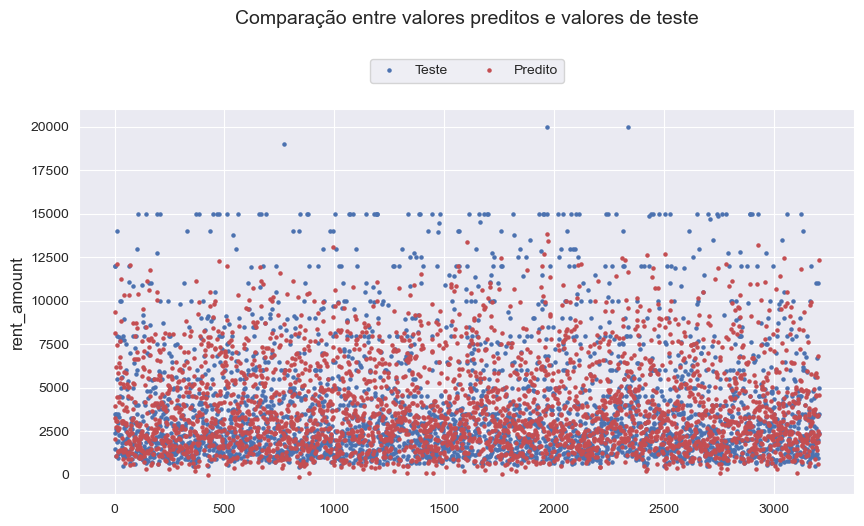

In [42]:
# Plota um gráfico de dispersão para a comparação entre valores preditos e valores de teste
plt.figure(figsize=(10,5))
plt.scatter([_ for _ in range(len(X_teste))], y_teste, color="C0", label="Teste", s=5)
plt.scatter([_ for _ in range(len(X_teste))], y_pred, color="C3", label="Predito", s=5)

plt.ylabel("rent_amount")
plt.title("Comparação entre valores preditos e valores de teste", y=1.2)
plt.legend(bbox_to_anchor=(0.5, 1.1), loc="center", ncols=2)

plt.show()

Por este gráfico é possível ver que o modelo consegue prever bem alugueis mais baratos, mas deixa a desejar para alugueis mais caros.

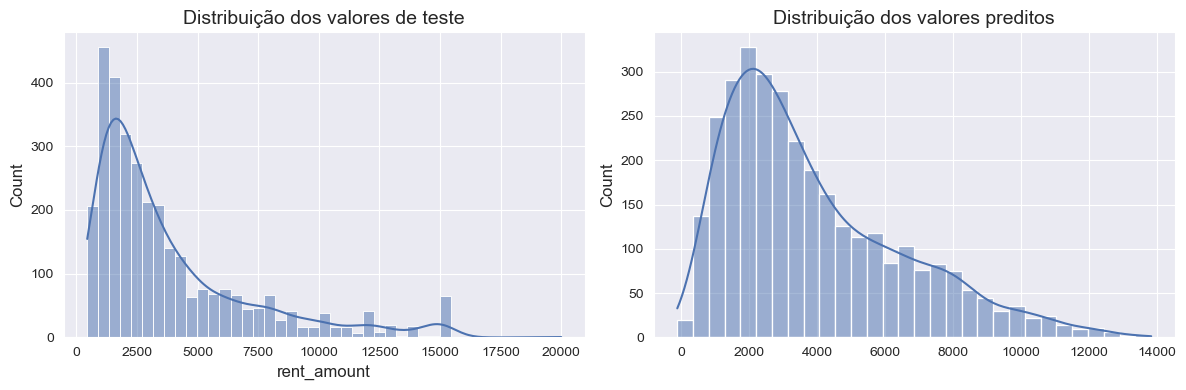

In [43]:
fig = plt.figure(figsize=(12, 4))

# Plota o histograma para os valores de teste
plt.subplot(1, 2, 1)
sns.histplot(y_teste, kde=True)
plt.title("Distribuição dos valores de teste")

# Plota o histograma para os valores preditos
plt.subplot(1, 2, 2)
sns.histplot(y_pred, kde=True)
plt.title("Distribuição dos valores preditos")

fig.tight_layout()
plt.show()

Por este gráfico é possível ver que a distribuição de ambos ficou parecida, com a maioria dos alugueis entre 1500 e 3000.

Vejamos para o modelo RandomForest.

## Random Forest Regressor

In [44]:
# Cria o modelo de random forest
forest = RandomForestRegressor(random_state=42, **best_params)

# Treina o modelo
forest.fit(X_treino_scaled, y_treino)

# Previsões em teste
y_pred = forest.predict(X_teste_scaled)

In [45]:
r2 = np.round(r2_score(y_teste, y_pred), 3)
rmse = np.round(np.sqrt(mean_squared_error(y_teste, y_pred)), 3)
mae = np.round(mean_absolute_error(y_teste, y_pred), 3)
print("\033[1m" + 12 * "*" + "Métricas" + 12 * "*" + "\033[0m")
print("R² Score:", r2)
print("RMSE:", rmse)
print("MAE:", mae)

************Métricas************
R² Score: 0.599
RMSE: 2109.775
MAE: 1303.575


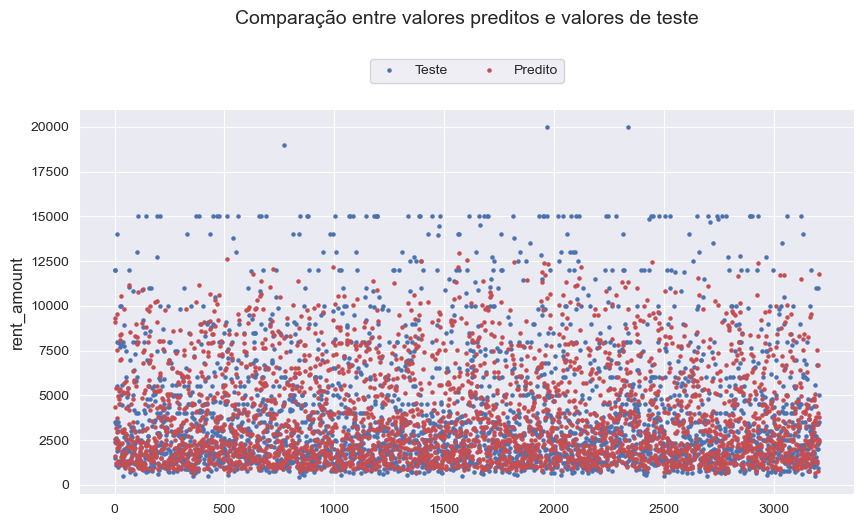

In [46]:
# Plota um gráfico de dispersão para a comparação entre valores preditos e valores de teste
plt.figure(figsize=(10,5))
plt.scatter([_ for _ in range(len(X_teste))], y_teste, color="C0", label="Teste", s=5)
plt.scatter([_ for _ in range(len(X_teste))], y_pred, color="C3", label="Predito", s=5)

plt.ylabel("rent_amount")
plt.title("Comparação entre valores preditos e valores de teste", y=1.2)
plt.legend(bbox_to_anchor=(0.5, 1.1), loc="center", ncols=2)

plt.show()

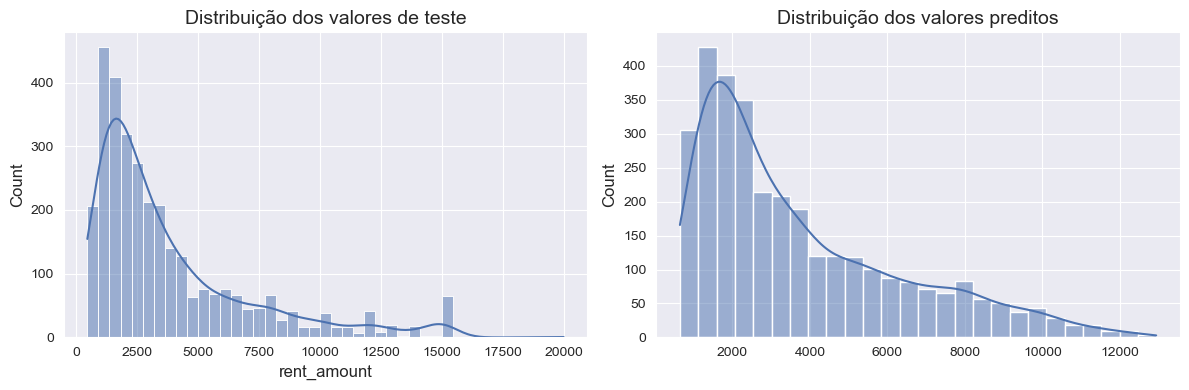

In [47]:
fig = plt.figure(figsize=(12, 4))

# Plota o histograma para os valores de teste
plt.subplot(1, 2, 1)
sns.histplot(y_teste, kde=True)
plt.title("Distribuição dos valores de teste")

# Plota o histograma para os valores preditos
plt.subplot(1, 2, 2)
sns.histplot(y_pred, kde=True)
plt.title("Distribuição dos valores preditos")

fig.tight_layout()
plt.show()

# Conclusão

O modelo <code>RandomForestRegressor()</code> com os melhores hiperparâmetros teve um desempenho levemente superior em relação ao <code>LinearRegression()</code>, dessa forma ele poderia ser levado para a produção.

O erro, apesar de relativamente alto, era esperado, visto que removemos algumas features redundantes que possuiam alta correlação. Em testes anteriores, deixando tais features, os modelos atingiam facilmente erros próximos de zero, um claro caso de overfitting.

Em versões posteriores, podem ser feitos testes para a inclusão de novas features, bem como técnicas ensemble e stacking.

# Teste com novos valores

In [48]:
# Iremos prever o aluguel de uma moradia em São Paulo com 50 m² de área
media = df.loc[(df["city"] == "São Paulo") & (df["area"] == 50)]["rent_amount"].mean()
print(f"A média do aluguel com essas características é de R$ {round(media, 2)}")

A média do aluguel com essas características é de R$ 1880.59


In [49]:
df.columns

Index(['city', 'area', 'rooms', 'bathroom', 'parking_spaces', 'floor',
       'animal', 'furniture', 'rent_amount'],
      dtype='object')

In [50]:
# Dados novos
nova_casa = [4, 50, 2, 1, 1, 10, 1, 0]

In [51]:
# Transforma a lista em array e aplica a transformação (padronização)
arr_casa = np.array(nova_casa)
arr_casa = scaler.transform(arr_casa.reshape(1, -1))

In [52]:
arr_casa

array([[ 0.75289236, -0.67652865, -0.43295446, -0.87627898, -0.39200799,
         0.91103031,  0.53266135, -0.5642252 ]])

In [53]:
# Faz a predição usando o modelo RandomForest
predicao = forest.predict(arr_casa)
print(f"O valor predito de uma moradia nas condições passadas é de R$ {round(predicao[0], 2)}")

O valor predito de uma moradia nas condições passadas é de R$ 1466.61
